In [19]:
import concurrent.futures
import json
from pathlib import Path

from virtual_lab.agent import Agent
from virtual_lab.constants import CONSISTENT_TEMPERATURE, CREATIVE_TEMPERATURE
from virtual_lab.prompts import (
    CODING_RULES,
    REWRITE_PROMPT,
    SCIENTIFIC_CRITIC,
    create_merge_prompt,
)
from virtual_lab.run_meeting import run_meeting
from virtual_lab.utils import load_summaries

In [2]:
# Set up key parameters
num_iterations = 5
num_rounds = 3
save_dir = Path("discussions")
model = "gpt-4o-2024-08-06"
background_prompt = "You are working on a research project to use machine learning to develop antibodies or nanobodies for the newest variant of the SARS-CoV-2 spike protein that also, ideally, have activity against other circulating minor variants and past variants."

## Team selection

In [3]:
# Team selection - prompts
team_selection_dir = save_dir / "team_selection"

team_selection_agenda = f"""{background_prompt} You need to select a team of three scientists to help you with this project. Please select the team members that you would like to invite to a discussion to create the antibody/nanobody design approach. Please list the team members in the following format, using the team member below as an example. You should not include yourself (Principal Investigator) in the list.

Agent(
    title="Principal Investigator",
    expertise="applying artificial intelligence to biomedical research",
    goal="perform research in your area of expertise that maximizes the scientific impact of the work",
    role="lead a team of experts to solve an important problem in artificial intelligence for biomedicine, make key decisions about the project direction based on team member input, and manage the project timeline and resources",
)
"""

In [ ]:
PRINCIPAL_INVESTIGATOR = Agent(
    title="Principal Investigator",
    expertise="applying artificial intelligence to biomedical research",
    goal="perform research in your area of expertise that maximizes the scientific impact of the work",
    role="lead a team of experts to solve an important problem in artificial intelligence for biomedicine, make key decisions about the project direction based on team member input, and manage the project timeline and resources",
)

In [ ]:
# Team selection - discussion
with concurrent.futures.ThreadPoolExecutor() as executor:
    concurrent.futures.wait([
        executor.submit(
            run_meeting,
            meeting_type="individual",
            team_member=PRINCIPAL_INVESTIGATOR,
            agenda=team_selection_agenda,
            save_dir=team_selection_dir,
            save_name=f"discussion_{iteration_num + 1}",
            temperature=CREATIVE_TEMPERATURE,
            model=model,
        ) for iteration_num in range(num_iterations)
    ])

In [ ]:
# Team selection - merge
team_selection_summaries = load_summaries(discussion_paths=list(team_selection_dir.glob("discussion_*.json")))
print(f"Number of summaries: {len(team_selection_summaries)}")

team_selection_merge_prompt = create_merge_prompt(agenda=team_selection_agenda)

run_meeting(
    meeting_type="individual",
    team_member=PRINCIPAL_INVESTIGATOR,
    summaries=team_selection_summaries,
    agenda=team_selection_merge_prompt,
    save_dir=team_selection_dir,
    save_name="merged",
    temperature=CONSISTENT_TEMPERATURE,
    model=model,
)

In [4]:
# Add team members
IMMUNOLOGIST = Agent(
    title="Immunologist",
    expertise="antibody engineering and immune response characterization",
    goal="guide the development of antibodies/nanobodies that elicit a strong and broad immune response",
    role="advise on immunogenicity, cross-reactivity with other variants, and potential for therapeutic application, ensuring the designs are viable for experimental validation and downstream applications",
)

MACHINE_LEARNING_SPECIALIST = Agent(
    title="Machine Learning Specialist",
    expertise="developing algorithms for protein-ligand interactions and optimization",
    goal="create and apply machine learning models to predict antibody efficacy and optimize binding affinity across SARS-CoV-2 variants",
    role="lead the development of AI tools for predicting interactions and refining antibody designs based on computational results",
)

COMPUTATIONAL_BIOLOGIST = Agent(
    title="Computational Biologist",
    expertise="protein structure prediction and molecular dynamics simulations",
    goal="develop predictive models to identify potential antibody/nanobody candidates and simulate interactions with the SARS-CoV-2 spike protein",
    role="provide insights into structural dynamics, guide virtual screening efforts, and validate computational predictions with simulations",
)

team_members = (
    IMMUNOLOGIST,
    MACHINE_LEARNING_SPECIALIST,
    COMPUTATIONAL_BIOLOGIST,
    SCIENTIFIC_CRITIC,
)

## Projects specification

In [5]:
# Project specification - prompts
project_specification_dir = save_dir / "project_specification"

project_specification_agenda = f"{background_prompt} Please create an antibody/nanobody design approach to solve this problem. Decide whether you will design antibodies or nanobodies. For your choice, decide whether you will design the antibodies/nanobodies de novo or whether you will modify existing antibodies/nanobodies. If modifying existing antibodies/nanobodies, please specify which antibodies/nanobodies to start with as good candidates for targeting the newest variant of the SARS-CoV-2 spike protein. If designing antibodies/nanobodies de novo, please describe how you will propose antibody/nanobody candidates."

project_specification_questions = (
    "Will you design standard antibodies or nanobodies?",
    "Will you design antibodies/nanobodies de novo or will you modify existing antibodies/nanobodies (choose only one)?",
    "If modifying existing antibodies/nanobodies, which precise antibodies/nanobodies will you modify (please list 3-4)?",
    "If designing antibodies/nanobodies de novo, how exactly will you propose antibody/nanobody candidates?",
)

In [ ]:
# Project specification - discussion
with concurrent.futures.ThreadPoolExecutor() as executor:
    concurrent.futures.wait([
        executor.submit(
            run_meeting,
            meeting_type="team",
            team_lead=PRINCIPAL_INVESTIGATOR,
            team_members=team_members,
            agenda=project_specification_agenda,
            agenda_questions=project_specification_questions,
            save_dir=project_specification_dir,
            save_name=f"discussion_{iteration_num + 1}",
            temperature=CREATIVE_TEMPERATURE,
            model=model,
            num_rounds=num_rounds,
        ) for iteration_num in range(num_iterations)
    ])

In [ ]:
# Project specification - merge
project_specification_summaries = load_summaries(discussion_paths=list(project_specification_dir.glob("discussion_*.json")))
print(f"Number of summaries: {len(project_specification_summaries)}")

project_specification_merge_prompt = create_merge_prompt(
    agenda=project_specification_agenda,
    agenda_questions=project_specification_questions,
)

run_meeting(
    meeting_type="individual",
    team_member=PRINCIPAL_INVESTIGATOR,
    summaries=project_specification_summaries,
    agenda=project_specification_merge_prompt,
    save_dir=project_specification_dir,
    save_name="merged",
    temperature=CONSISTENT_TEMPERATURE,
    model=model,
    num_rounds=num_rounds,
)

In [6]:
nanobody_prompt = "Your team previous decided to modify existing nanobodies to improve their binding to the newest variant of the SARS-CoV-2 spike protein."

## Tools Selection

In [7]:
# Tools selection - prompts
tools_selection_dir = save_dir / "tools_selection"

tools_selection_agenda = f"{background_prompt} {nanobody_prompt} Now you need to select machine learning and/or computational tools to implement this nanobody design approach. Please list several tools (5-10) that would be relevant to this nanobody design approach and how they could be used in the context of this project. If selecting machine learning tools, please prioritize pre-trained models (e.g., pre-trained protein language models or protein structure prediction models) for simplicity."

tools_selection_questions = (
    "What machine learning and/or computational tools could be used for this nanobody design approach (list 5-10)?",
    "For each tool, how could it be used for designing modified nanobodies?",
)

tools_selection_prior_summaries = load_summaries(discussion_paths=[project_specification_dir / "merged.json"])
print(f"Number of prior summaries: {len(tools_selection_prior_summaries)}")

Number of prior summaries: 1


In [ ]:
# Tools selection - discussion
with concurrent.futures.ThreadPoolExecutor() as executor:
    concurrent.futures.wait([
        executor.submit(
            run_meeting,
            meeting_type="team",
            team_lead=PRINCIPAL_INVESTIGATOR,
            team_members=team_members,
            summaries=tools_selection_prior_summaries,
            agenda=tools_selection_agenda,
            agenda_questions=tools_selection_questions,
            save_dir=tools_selection_dir,
            save_name=f"discussion_{iteration_num + 1}",
            temperature=CREATIVE_TEMPERATURE,
            model=model,
            num_rounds=num_rounds,
        ) for iteration_num in range(num_iterations)
    ])

In [ ]:
# Tools selection - merge
tools_selection_summaries = load_summaries(discussion_paths=list(tools_selection_dir.glob("discussion_*.json")))
print(f"Number of summaries: {len(tools_selection_summaries)}")

tools_selection_merge_prompt = create_merge_prompt(
    agenda=tools_selection_agenda,
    agenda_questions=tools_selection_questions,
)

run_meeting(
    meeting_type="individual",
    team_member=PRINCIPAL_INVESTIGATOR,
    summaries=tools_selection_summaries,
    agenda=tools_selection_merge_prompt,
    save_dir=tools_selection_dir,
    save_name="merged",
    temperature=CONSISTENT_TEMPERATURE,
    model=model,
    num_rounds=num_rounds,
)

## Implementation

### ESM

In [8]:
# ESM - prompts
esm_dir = save_dir / "esm"

esm_agenda = f"{background_prompt} {nanobody_prompt} Now you must use ESM to suggest modifications to an existing antibody. Please write a complete Python script that takes a nanobody sequence as input and uses ESM amino acid log-likelihoods to identify the most promising point mutations by log-likelihood ratio."

In [ ]:
# ESM - discussion
with concurrent.futures.ThreadPoolExecutor() as executor:
    concurrent.futures.wait([
        executor.submit(
            run_meeting,
            meeting_type="individual",
            team_member=MACHINE_LEARNING_SPECIALIST,
            agenda=esm_agenda,
            agenda_rules=CODING_RULES,
            save_dir=esm_dir,
            save_name=f"discussion_{iteration_num + 1}",
            temperature=CREATIVE_TEMPERATURE,
            model=model,
            num_rounds=num_rounds,
        ) for iteration_num in range(num_iterations)
    ])

In [ ]:
# ESM - merge
esm_summaries = load_summaries(discussion_paths=list(esm_dir.glob("discussion_*.json")))
print(f"Number of summaries: {len(esm_summaries)}")

esm_merge_prompt = create_merge_prompt(
    agenda=esm_agenda,
    agenda_rules=CODING_RULES,
)

run_meeting(
    meeting_type="individual",
    team_member=MACHINE_LEARNING_SPECIALIST,
    summaries=esm_summaries,
    agenda=esm_merge_prompt,
    save_dir=esm_dir,
    save_name="merged",
    temperature=CONSISTENT_TEMPERATURE,
    model=model,
)

### Improve ESM

In [9]:
# Improve ESM - prompts
improve_esm_agenda = f"""You previously wrote a Python script that uses ESM to compute the log-likelihood ratio of point mutations in a nanobody sequence (see summary). {REWRITE_PROMPT}

1. Replace "facebook/esm1b-t33_650M_UR50S" with "facebook/esm1b_t33_650M_UR50S".
2. Run the calculations of the mutant log-likelihoods by iterating through the sequences in batches of 16.
3. Add a progress bar to the batched mutant log-likelihood calculations.
4. Run the mutant log-likelihood calculations on CUDA but with no gradients.
5. Load the nanobody sequence from a user-specified CSV file that has the columns "sequence" and "name". Adapt your code to run the mutant log-likelihood calculations on all sequences in the CSV file one-by-one.
6. For each sequence, save the mutant log-likelihoods to a CSV file with the format "mutated_sequence,position,original_aa,mutated_aa,log_likelihood_ratio". Ask the user for a save directory and then save this CSV file in that directory with the name: <nanbody-name>.csv."""

In [ ]:
# Improve ESM - discussion
improve_esm_summaries = load_summaries(discussion_paths=list(esm_dir.glob("merged.json")))
print(f"Number of summaries: {len(improve_esm_summaries)}")

run_meeting(
    meeting_type="individual",
    team_member=MACHINE_LEARNING_SPECIALIST,
    summaries=improve_esm_summaries,
    agenda=improve_esm_agenda,
    save_dir=esm_dir,
    save_name="improved",
    temperature=CONSISTENT_TEMPERATURE,
    model=model,
)

### AlphaFold-Multimer

In [10]:
# AlphaFold-Multimer - prompts
alphafold_dir = save_dir / "alphafold"

alphafold_agenda = f"{background_prompt} {nanobody_prompt} Now you must use AlphaFold-Multimer to predict the structure of a nanobody-antigen complex and evaluate its binding. I will run AlphaFold-Multimer on several nanobody-antigen complexes and you need to process the outputs. Please write a complete Python script that takes as input a directory containing PDB files where each PDB file contains one nanobody-antigen complex predicted by AlphaFold-Multimer and outputs a CSV file containing the AlphaFold-Multimer confidence of each nanobody-antigen complex in terms of the interface pLDDT."

In [ ]:
# AlphaFold-Multimer - discussion
with concurrent.futures.ThreadPoolExecutor() as executor:
    concurrent.futures.wait([
        executor.submit(
            run_meeting,
            meeting_type="individual",
            team_member=COMPUTATIONAL_BIOLOGIST,
            agenda=alphafold_agenda,
            agenda_rules=CODING_RULES,
            save_dir=alphafold_dir,
            save_name=f"discussion_{iteration_num + 1}",
            temperature=CREATIVE_TEMPERATURE,
            model=model,
            num_rounds=num_rounds,
        ) for iteration_num in range(num_iterations)
    ])

In [ ]:
# AlphaFold-Multimer - merge
alphafold_summaries = load_summaries(discussion_paths=list(alphafold_dir.glob("discussion_*.json")))
print(f"Number of summaries: {len(alphafold_summaries)}")

alphafold_merge_prompt = create_merge_prompt(
    agenda=alphafold_agenda,
    agenda_rules=CODING_RULES,
)

run_meeting(
    meeting_type="individual",
    team_member=COMPUTATIONAL_BIOLOGIST,
    summaries=alphafold_summaries,
    agenda=alphafold_merge_prompt,
    save_dir=alphafold_dir,
    save_name="merged",
    temperature=CONSISTENT_TEMPERATURE,
    model=model,
)

### Improve AlphaFold-Multimer

In [11]:
# Improve AlphaFold-Multimer - prompts
improve_alphafold_agenda = f"""You previously wrote a Python script that processes the outputs of AlphaFold-Multimer to calculate the confidence of nanobody-antigen complexes (see summary). {REWRITE_PROMPT}

1. Replace the current imports of Chain and Residue with "from Bio.PDB.Chain import Chain" and "from Bio.PDB.Residue import Residue".
2. Remove the logging setup and simply print any log messages to the console.
3. Replace the parallel processing with sequential processing to avoid getting an "OSError: Too many open files".
4. Change the list of pdb_files to instead get all PDB files in the directory that follow the pattern "**/*unrelaxed_rank_001*.pdb".
5. Change the calculation of average pLDDT to divide by the number of atoms rather than the number of residues.
6. Return and save in the CSV both the number of residues and the number of atoms in the interface.
7. Change the default distance threshold to 4."""

In [ ]:
# Improve AlphaFold-Multimer - discussion
improve_alphafold_summaries = load_summaries(discussion_paths=list(alphafold_dir.glob("merged.json")))
print(f"Number of summaries: {len(improve_alphafold_summaries)}")

run_meeting(
    meeting_type="individual",
    team_member=COMPUTATIONAL_BIOLOGIST,
    summaries=improve_alphafold_summaries,
    agenda=improve_alphafold_agenda,
    save_dir=alphafold_dir,
    save_name="improved",
    temperature=CONSISTENT_TEMPERATURE,
    model=model,
)

### Rosetta

In [12]:
# Rosetta - prompts
rosetta_dir = save_dir / "rosetta"

rosetta_agenda = f"{background_prompt} {nanobody_prompt} Now you must use Rosetta to calculate the binding energy of nanobody-antigen complexes. You must do this in three parts. First, write a complete RosettaScripts XML file that calculates the binding energy of a nanobody-antigen complex as provided in PDB format, including any necessary preprocessing steps for the complex. Second, write an example command that uses Rosetta to run this RosettaScripts XML file on a given PDB file to calculate the binding energy and save it to a score file. Third, write a complete Python script that takes as input a directory with multiple Rosetta binding energy score files and outputs a single CSV file with the names and scores of each of the individual files in sorted order (highest to lowest score)."

In [ ]:
# Rosetta - discussion
with concurrent.futures.ThreadPoolExecutor() as executor:
    concurrent.futures.wait([
        executor.submit(
            run_meeting,
            meeting_type="individual",
            team_member=COMPUTATIONAL_BIOLOGIST,
            agenda=rosetta_agenda,
            agenda_rules=CODING_RULES,
            save_dir=rosetta_dir,
            save_name=f"discussion_{iteration_num + 1}",
            temperature=CREATIVE_TEMPERATURE,
            model=model,
            num_rounds=num_rounds,
        ) for iteration_num in range(num_iterations)
    ])

In [ ]:
# Rosetta - merge
rosetta_summaries = load_summaries(discussion_paths=list(rosetta_dir.glob("discussion_*.json")))
print(f"Number of summaries: {len(rosetta_summaries)}")

rosetta_merge_prompt = create_merge_prompt(
    agenda=rosetta_agenda,
    agenda_rules=CODING_RULES,
)

run_meeting(
    meeting_type="individual",
    team_member=COMPUTATIONAL_BIOLOGIST,
    summaries=rosetta_summaries,
    agenda=rosetta_merge_prompt,
    save_dir=rosetta_dir,
    save_name="merged",
    temperature=CONSISTENT_TEMPERATURE,
    model=model,
)

### Improve Rosetta

In [13]:
# Improve Rosetta XML - prompts
improve_rosetta_xml_agenda = f"""You previously wrote a RosettaScripts XML file to calculate the binding affinity of a nanobody-antigen complex (see summary). {REWRITE_PROMPT}

1. Replace "ref15.wts" with "ref2015.wts".
2. Remove the InterfaceEnergy filter since it is not valid in Rosetta.
3. Replace the entire output tag (including any nested tags) with <OUTPUT scorefxn="ref15"/>."""

In [ ]:
# Improve Rosetta XML - discussion
improve_rosetta_xml_summaries = load_summaries(discussion_paths=list(rosetta_dir.glob("merged.json")))
print(f"Number of summaries: {len(improve_rosetta_xml_summaries)}")

run_meeting(
    meeting_type="individual",
    team_member=COMPUTATIONAL_BIOLOGIST,
    summaries=improve_rosetta_xml_summaries,
    agenda=improve_rosetta_xml_agenda,
    save_dir=rosetta_dir,
    save_name="improved_xml",
    temperature=CONSISTENT_TEMPERATURE,
    model=model,
)

In [14]:
# Improve Rosetta Python - prompts
improve_rosetta_python_agenda = f"""You previously wrote a Python script to aggregate multiple Rosetta binding energy score files into one CSV file (see summary). {REWRITE_PROMPT}

1. Modify the extract_scores_from_file function so that it extracts the dG_separated value from a file of the following form.

SEQUENCE:
SCORE: total_score complex_normalized           dG_cross dG_cross/dSASAx100 dG_separated dG_separated/dSASAx100 dSASA_hphobic dSASA_int dSASA_polar delta_unsatHbonds dslf_fa13    fa_atr    fa_dun   fa_elec fa_intra_rep fa_intra_sol_xover4              fa_rep              fa_sol hbond_E_fraction hbond_bb_sc hbond_lr_bb    hbond_sc hbond_sr_bb hbonds_int lk_ball_wtd    nres_all    nres_int       omega     p_aa_pp    packstat per_residue_energy_int pro_close rama_prepro         ref    sc_value side1_normalized side1_score side2_normalized side2_score yhh_planarity description
SCORE:    -990.807             -2.914            -21.436             -1.857      -21.436                 -1.857       774.274  1154.088     379.813            12.000    -3.867 -1928.622   376.416  -541.777        3.745              54.944             265.303            1052.322            0.053     -84.023    -130.532     -54.069     -46.266      1.000     -41.725     340.000      55.000      39.977     -81.331       0.000                 -2.699     2.349      -6.870     131.513       0.000           -2.236     -51.431           -3.031     -97.008         1.706 KP3_Ty1-G59Y_unrelaxed_rank_001_alphafold2_multimer_v3_model_3_seed_000_0001"""

In [ ]:
# Improve Rosetta Python - discussion
improve_rosetta_python_summaries = load_summaries(discussion_paths=list(rosetta_dir.glob("merged.json")))
print(f"Number of summaries: {len(improve_rosetta_python_summaries)}")

run_meeting(
    meeting_type="individual",
    team_member=COMPUTATIONAL_BIOLOGIST,
    summaries=improve_rosetta_python_summaries,
    agenda=improve_rosetta_python_agenda,
    save_dir=rosetta_dir,
    save_name="improved_python",
    temperature=CONSISTENT_TEMPERATURE,
    model=model,
)

## Workflow Design

In [15]:
# Workflow design - prompts
workflow_design_dir = save_dir / "workflow_design"

workflow_design_agenda = f"{background_prompt} {nanobody_prompt} Your team has built three components of a nanobody design pipeline: ESM, AlphaFold-Multimer, and Rosetta. Each of these three tools can be used to score a nanobody mutation based on how the mutation affects binding to an antigen. Your goal is to start with an existing nanobody and iteratively add mutations to it to improve its binding to the newest variant of the SARS-CoV-2 spike protein, resulting in 24 modified nanobodies with one or more mutations. Please determine how to use ESM, AlphaFold-Multimer, and Rosetta in this iterative design process. An important constraint is that ESM can evaluate all potential mutations to a nanobody in 5 minutes while AlphaFold-Multimer takes 30 minutes per mutation and Rosetta takes five minutes per mutation. The whole iterative process should take no more than a few days to complete. Note that AlphaFold-Multimer must be run before Rosetta on each mutation since Rosetta requires the nanobody-antigen structure predicted by AlphaFold-Multimer. Additionally, note that ESM log-likelihood ratios are generally in the range of 5-10 (higher is better), AlphaFold-Multimer interface pLDDT confidence scores are generally in the range of 60-80 (higher is better), and Rosetta binding energy scores are generally in the range of -20 to -40 (lower is better)."

workflow_design_questions = (
    "In each iteration, what is the order of operations for evaluating mutations with ESM, AlphaFold-Multimer, and Rosetta?",
    "In each iteration, how many mutations (give a single number) will you evaluate with ESM, AlphaFold-Multimer, and Rosetta?",
    "At the end of each iteration, how will you weigh the ESM, AlphaFold-Multimer, and/or Rosetta scores (give a formula) to rank the nanobody mutations?",
    "At the end of each iteration, how many of the top-ranked mutations (give a single number) will you keep for the next round?",
    "How will you decide how many iterations of mutations to run?",
    "After all of the iterations are complete, how exactly (step-by-step) will you select the final set of 24 modified nanobodies from across the iterations for experimental validation?",
)

In [ ]:
# Workflow design - discussion
with concurrent.futures.ThreadPoolExecutor() as executor:
    concurrent.futures.wait([
        executor.submit(
            run_meeting,
            meeting_type="individual",
            team_member=PRINCIPAL_INVESTIGATOR,
            agenda=workflow_design_agenda,
            agenda_questions=workflow_design_questions,
            save_dir=workflow_design_dir,
            save_name=f"discussion_{iteration_num + 1}",
            temperature=CREATIVE_TEMPERATURE,
            model=model,
        ) for iteration_num in range(num_iterations)
    ])

In [ ]:
# Workflow design - merge
workflow_design_summaries = load_summaries(discussion_paths=list(workflow_design_dir.glob("discussion_*.json")))
print(f"Number of summaries: {len(workflow_design_summaries)}")

workflow_design_merge_prompt = create_merge_prompt(
    agenda=workflow_design_agenda,
    agenda_questions=workflow_design_questions,
)

run_meeting(
    meeting_type="individual",
    team_member=PRINCIPAL_INVESTIGATOR,
    summaries=workflow_design_summaries,
    agenda=workflow_design_merge_prompt,
    save_dir=workflow_design_dir,
    save_name="merged",
    temperature=CONSISTENT_TEMPERATURE,
    model=model,
)

## Virtual Lab Analysis

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

In [35]:
phase_to_agent_to_word_count = {}

In [40]:
# Count words that the human user wrote
phase_to_human_words = {
    "team_selection":  [
        background_prompt,
        PRINCIPAL_INVESTIGATOR.prompt,
        SCIENTIFIC_CRITIC.prompt,
        team_selection_agenda.replace(f"{background_prompt} ", ""),
    ],
    "project_specification": [
        project_specification_agenda.replace(f"{background_prompt} ", ""),
        *project_specification_questions,
        nanobody_prompt,
    ],
    "tools_selection": [
        tools_selection_agenda.replace(f"{background_prompt} {nanobody_prompt} ", ""),
        *tools_selection_questions,
    ],
    "esm": [
        esm_agenda.replace(f"{background_prompt} {nanobody_prompt} ", ""),
        improve_esm_agenda.replace(f" {REWRITE_PROMPT}", ""),
    ],
    "alphafold": [
        alphafold_agenda.replace(f"{background_prompt} {nanobody_prompt} ", ""),
        improve_alphafold_agenda.replace(f" {REWRITE_PROMPT}", ""),
    ],
    "rosetta": [
        rosetta_agenda.replace(f"{background_prompt} {nanobody_prompt} ", ""),
        improve_rosetta_xml_agenda.replace(f" {REWRITE_PROMPT}", ""),
        improve_rosetta_python_agenda.replace(f" {REWRITE_PROMPT}", ""),
    ],
    "workflow_design": [
        workflow_design_agenda.replace(f"{background_prompt} {nanobody_prompt} ", ""),
        *workflow_design_questions,
    ],
}

for phase, human_words in phase_to_human_words.items():
    phase_to_agent_to_word_count[phase] = {"Human Researcher": len(" ".join(human_words).split())}

In [41]:
# Count words that the LLM agents wrote
for phase_dir in [team_selection_dir, project_specification_dir, tools_selection_dir, esm_dir, alphafold_dir, rosetta_dir, workflow_design_dir]:
    phase_name = phase_dir.name

    print(f"Phase: {phase_name}")

    # Load the text written by each agent
    agent_to_text = {}
    for path in phase_dir.glob("*.json"):
        with open(path) as f:
            discussion = json.load(f)

        for message in discussion:
            agent_to_text.setdefault(message["agent"], []).append(message["message"])

    # Count the number of words written by each agent
    for agent, text in agent_to_text.items():
        if agent == "User":
            continue

        agent_to_text[agent] = " ".join(text)
        word_count = len(agent_to_text[agent].split())
        phase_to_agent_to_word_count[phase_name][agent] = word_count

# Print words by phase
for phase in phase_to_agent_to_word_count:
    print(f"Phase: {phase}")
    for agent, word_count in phase_to_agent_to_word_count[phase].items():
        print(f"Number of words written by {agent}: {word_count:,}")
    print()

# Sum word counts across phases
agent_to_word_count = {}
for phase in phase_to_agent_to_word_count:
    for agent, word_count in phase_to_agent_to_word_count[phase].items():
        agent_to_word_count[agent] = agent_to_word_count.get(agent, 0) + word_count

# Total number of words written by each LLM agent
for agent, word_count in agent_to_word_count.items():
    print(f"Total number of words written by {agent}: {word_count:,}")

print()

# Total number of words written by all LLM agents
total_human_words = sum(phase_to_agent_to_word_count[phase]["Human Researcher"] for phase in phase_to_agent_to_word_count)
total_agent_words = sum(word_count for agent, word_count in agent_to_word_count.items() if agent != "Human Researcher")

print(f"Total number of words written by Human Researcher: {total_human_words:,}")
print(f"Total number of words written by all LLM agents: {total_agent_words:,}")

Phase: team_selection
Phase: project_specification
Phase: tools_selection
Phase: esm
Phase: alphafold
Phase: rosetta
Phase: workflow_design
Phase: team_selection
Number of words written by Human Researcher: 294
Number of words written by Principal Investigator: 1,296

Phase: project_specification
Number of words written by Human Researcher: 142
Number of words written by Principal Investigator: 10,513
Number of words written by Scientific Critic: 6,068
Number of words written by Immunologist: 3,684
Number of words written by Machine Learning Specialist: 4,186
Number of words written by Computational Biologist: 4,277

Phase: tools_selection
Number of words written by Human Researcher: 91
Number of words written by Principal Investigator: 11,035
Number of words written by Scientific Critic: 6,318
Number of words written by Immunologist: 3,566
Number of words written by Machine Learning Specialist: 4,399
Number of words written by Computational Biologist: 4,498

Phase: esm
Number of words

In [46]:
agent_to_color = {
    agent: sns.color_palette("tab10", n_colors=len(agent_to_word_count))[i]
    for i, agent in enumerate(agent_to_word_count)
}

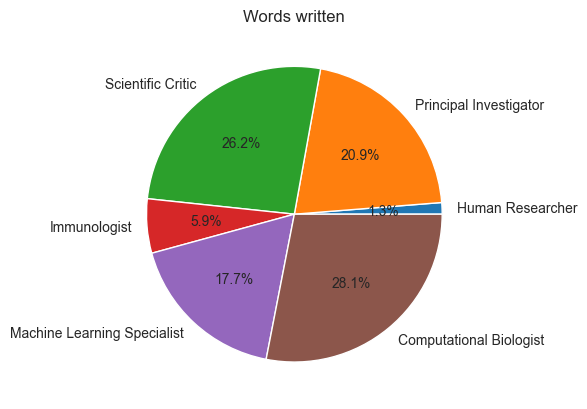

In [48]:
plt.pie(
    agent_to_word_count.values(),
    labels=agent_to_word_count.keys(),
    autopct="%1.1f%%",
    colors=[agent_to_color[agent] for agent in agent_to_word_count],
)
plt.title(f"Words written")
plt.show()

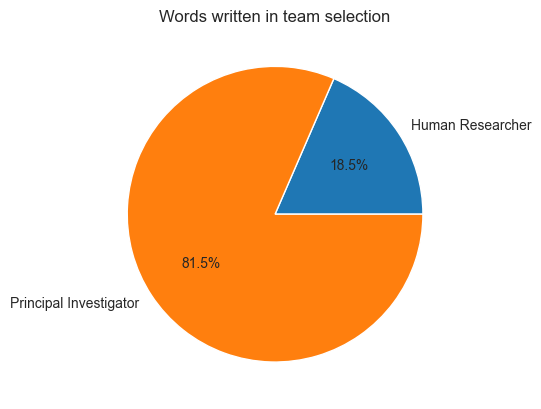

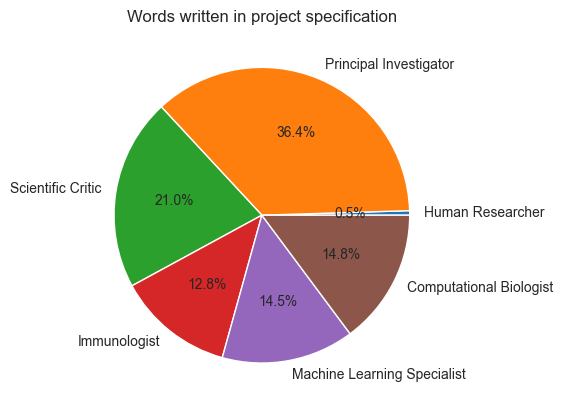

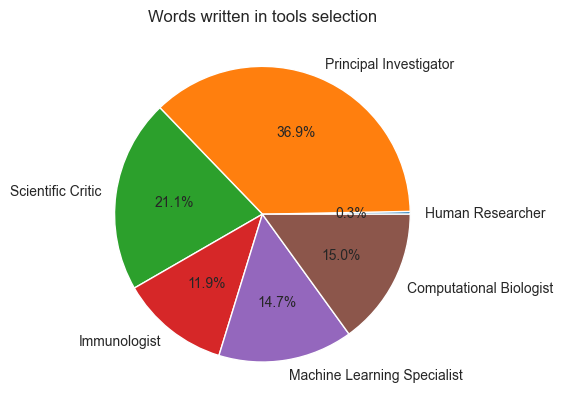

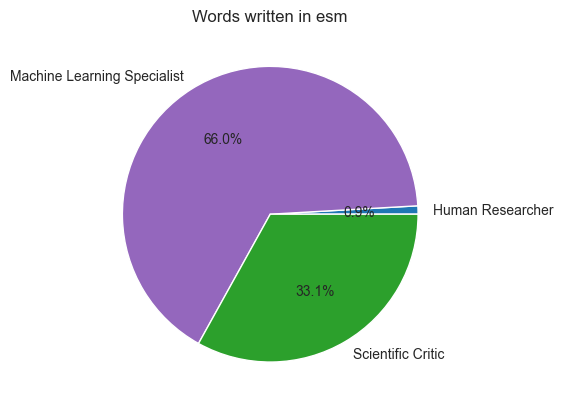

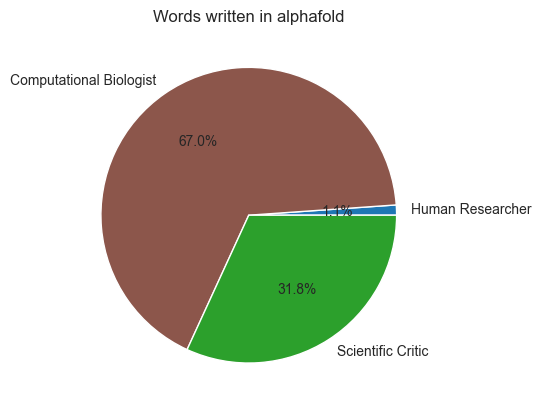

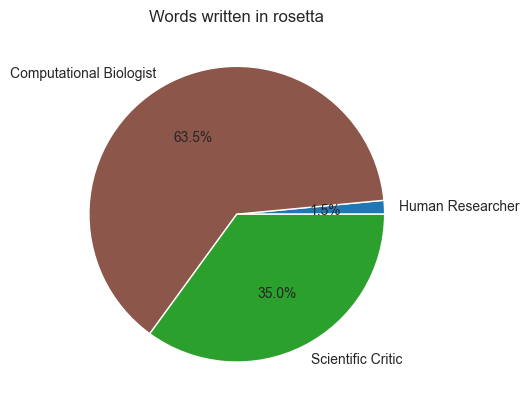

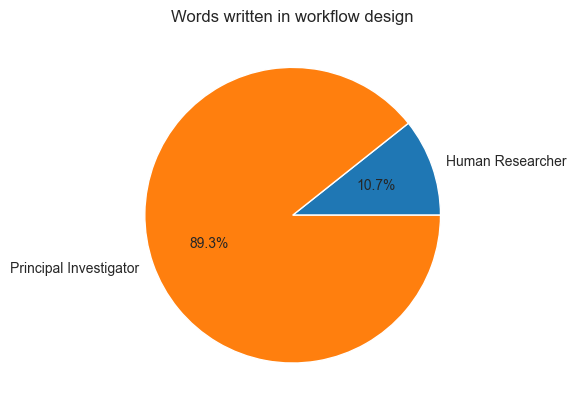

In [47]:
for phase in phase_to_agent_to_word_count:
    plt.pie(
        phase_to_agent_to_word_count[phase].values(),
        labels=phase_to_agent_to_word_count[phase].keys(),
        autopct="%1.1f%%",
        colors=[agent_to_color[agent] for agent in phase_to_agent_to_word_count[phase]],
    )
    plt.title(f"Words written in {phase.replace('_', ' ')}")
    plt.show()